In [1]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
pd.set_option("display.max_columns", 50)
sys.path.insert(0,'/home/oem/Projects/Kylearn')
from Models.Mean_Teacher.mean_teacher_dataset import Mean_Teacher_dataset

In [3]:
import matplotlib.pyplot as pyplot
import numpy as np
import pandas as pd
import seaborn as sb
import math
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report

pyplot.rcParams['savefig.dpi'] = 300  # pixel
pyplot.rcParams['figure.dpi'] = 300  # resolution
pyplot.rcParams["figure.figsize"] = [10,8] # figure size

def draw_confusion_matrix(cm, labels, plt = pyplot, x_rotation=90, y_rotation=0, font_size=0.33, precision=False):


    if (precision):
        '''flip and rotate the confusion metrix'''
        labels = labels[::-1]
        cm = np.rot90(np.flip(cm, axis=0))

    cm_sum = np.sum(cm, axis=1, keepdims=True)

    cm_perc = cm / cm_sum.astype(float) * 100

    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif (c == 0):
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)

    if (precision):
        cm.columns.name = 'True Label'
        cm.index.name = 'Predict Label'
    else:
        cm.index.name = 'True Label'
        cm.columns.name = 'Predict Label'

    sb.set(font_scale=font_size)

    sb.heatmap(cm, annot=annot, fmt='', cmap='Blues')
    plt.xticks(rotation=x_rotation)
    plt.yticks(rotation=y_rotation)

    plt.show()

# get metrics for binary classification
def metrics_binary(y_pred, threshold, y_test):
    y_pred_copy = y_pred.copy()
    y_pred_copy[y_pred_copy >= threshold] = 1
    y_pred_copy[y_pred_copy < threshold] = 0
    cm = confusion_matrix(y_test, y_pred_copy)
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    fpr = fp / (fp + tn)
    accuracy = (tp + tn) / (np.sum(cm))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print('accuracy: ' + str(accuracy) + '\n')
    print('precision: ' + str(precision) + '\n')
    print('recall: ' + str(recall) + '\n')
    print('false positive rate: ' + str(fpr) + '\n')
    return cm, fpr, accuracy, precision, recall

In [4]:
# Functions for drawing ROC
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve

def auc_roc(y_pred, y_test):
    auc = roc_auc_score(y_true=y_test, y_score=y_pred)
    fprs, tprs, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    return auc, fprs, tprs, thresholds

import matplotlib.pyplot as pyplot
pyplot.rcParams['savefig.dpi'] = 300  # pixel
pyplot.rcParams['figure.dpi'] = 300  # resolution
pyplot.rcParams["figure.figsize"] = [4,3] # figure size

def plot_roc_curve(fprs, tprs, auc, x_axis = 1, plt = pyplot):

    plt.plot(fprs, tprs, color="darkorange", label='ROC curve (area = %0.3f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, x_axis])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [5]:
def visualize_input_attention(matrix, dev_list, pm_list):
    attn_matrix = pd.DataFrame(data=matrix, index=dev_list, columns=pm_list)
    attn_matrix[attn_matrix == 1] = 0
    attn_matrix[attn_matrix == 0] = 'x'
    return attn_matrix

In [6]:
dev_list = ['AMP', 'ETH10G', 'ETHN', 'ETTP', 'OC192', 'OPTMON', 'OSC', 'OTM', 'OTM2', 'OTUTTP', 'PTP']

pm_list = ['BBE-RS',
            'CV-OTU', 'CV-S',
            'DROPGAINAVG-OTS', 'DROPGAINMAX-OTS_DROPGAINMIN-OTS_-',
            'E-CV', 'E-ES', 'E-INFRAMESERR_E-INFRAMES_/', 'E-OUTFRAMESERR_E-OUTFRAMES_/',
            'E-UAS', 'ES-OTU', 'ES-RS', 'ES-S',
            'OCH-OPRAVG', 'OCH-OPRMAX_OCH-OPRMIN_-', 'OCH-SPANLOSSAVG', 'OCH-SPANLOSSMAX_OCH-SPANLOSSMIN_-',
            'OPINAVG-OTS', 'OPINMAX-OTS_OPINMIN-OTS_-',
            'OPOUTAVG-OTS', 'OPOUTAVG-OTS_OPINAVG-OTS_-', 'OPOUTMAX-OTS_OPOUTMIN-OTS_-',
            'OPRAVG-OCH', 'OPRAVG-OTS', 'OPRMAX-OCH_OPRMIN-OCH_-', 'OPRMAX-OTS_OPRMIN-OTS_-',
            'OPTAVG-OCH', 'OPTAVG-OTS', 'OPTMAX-OCH_OPTMIN-OCH_-', 'OPTMAX-OTS_OPTMIN-OTS_-',
            'ORLAVG-OTS', 'ORLMIN-OTS', 'OTU-CV', 'OTU-ES', 'OTU-QAVG', 'OTU-QSTDEV',
            'PCS-CV', 'PCS-ES', 'PCS-UAS',
            'QAVG-OTU', 'QSTDEV-OTU',
            'RS-BBE', 'RS-ES',
            'S-CV', 'S-ES']

In [7]:
# Restore model
number = 7300
sess = tf.Session()
saver = tf.train.import_meta_graph('models/-%s.meta'%str(number))
saver.restore(sess=sess, save_path='models/-%s'%str(number))
graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from models/-7300


In [8]:
# Get tensors
input_x = graph.get_tensor_by_name('input/features:0')
input_dev = graph.get_tensor_by_name('input/dev_type:0')
is_training = graph.get_tensor_by_name('input/is_training:0')
output_proba = graph.get_tensor_by_name('error/Sigmoid:0')
attention_matrix = graph.get_tensor_by_name('scaling_attention/LeakyRelu:0') 

In [9]:
dataset = Mean_Teacher_dataset(feature_path='data/X',
                               dev_path= 'data/dev',
                               label_path='data/y',
                               unlabeled_feature_path='data/X_un',
                               unlabeled_dev_path='data/dev_un'
                               )

In [12]:
import collections
print(collections.Counter(dataset.train_set['y']))
print(collections.Counter(dataset.test_set['y']))

Counter({0: 1404516, 1: 5875})
Counter({0: 341169, 1: 1430})


accuracy: 0.9984

precision: 0.9752066115702479

recall: 0.659217877094972

false positive rate: 7.533713367318751e-05

accuracy: 0.998400


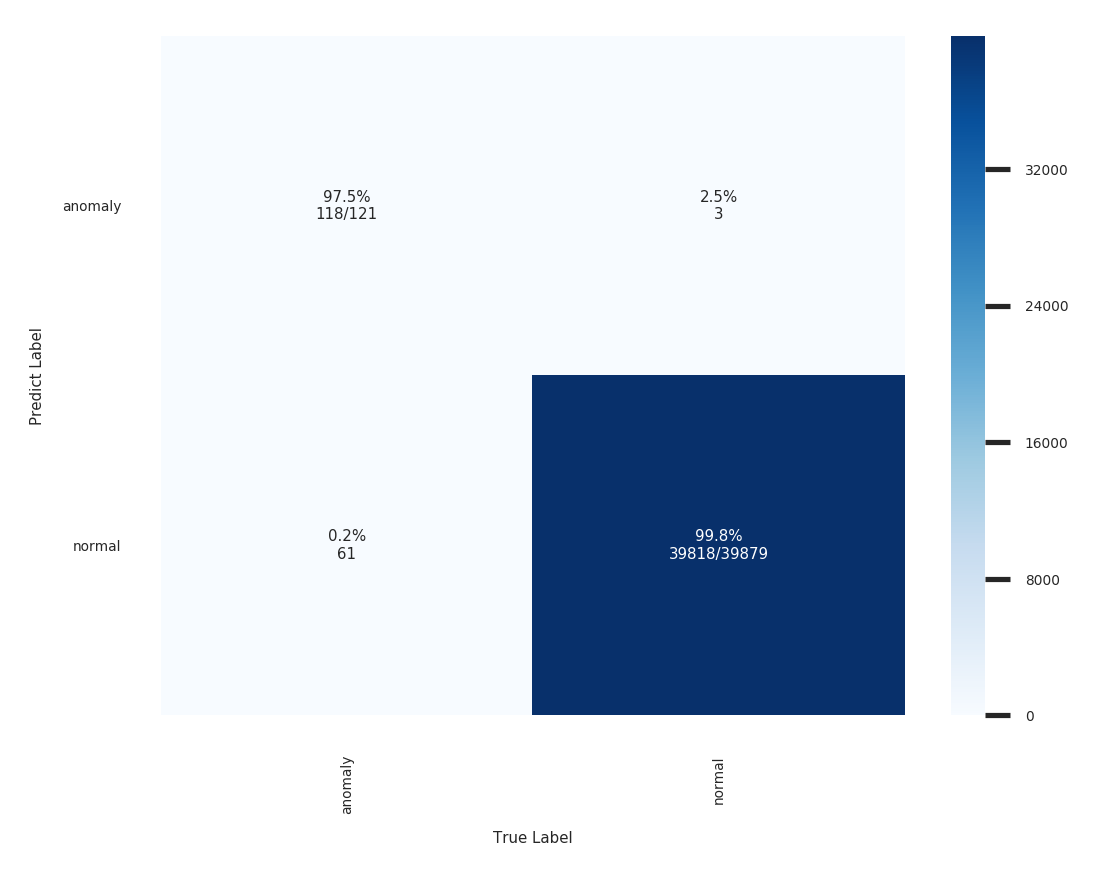

In [18]:
# Output prediction of 40,000 test data
proba = sess.run(output_proba, feed_dict={input_x: dataset.test_set['x'][:40000],
                                           input_dev: dataset.test_set['dev'][:40000],
                                           is_training: False})

cm, fpr, accuracy, precision, recall = metrics_binary(
    y_pred=proba, y_test=dataset.test_set['y'][:40000],threshold=0.9)

print('accuracy: %f'%accuracy)
draw_confusion_matrix(cm,  ['normal', 'anomaly'], precision=True, plt=pyplot, font_size = 0.3)


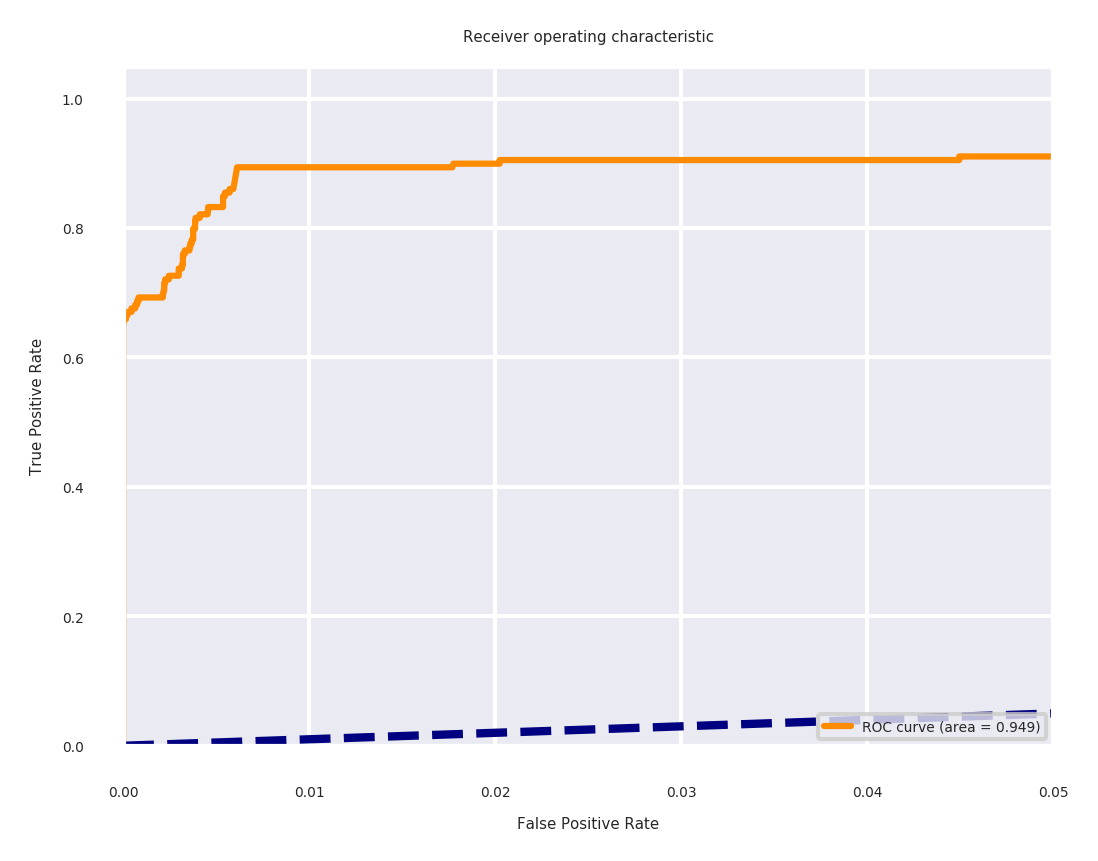

In [21]:
auc, fprs, tprs, thresholds = auc_roc(y_pred=proba, y_test=dataset.test_set['y'][:40000])
plot_roc_curve(fprs, tprs, auc, x_axis=0.05)

In [22]:
attn_matrix_input = sess.run(attention_matrix)

In [24]:
attn_matrix_input = visualize_input_attention(attn_matrix_input, dev_list, pm_list)
attn_matrix_input

,BBE-RS,CV-OTU,CV-S,DROPGAINAVG-OTS,DROPGAINMAX-OTS_DROPGAINMIN-OTS_-,E-CV,E-ES,E-INFRAMESERR_E-INFRAMES_/,E-OUTFRAMESERR_E-OUTFRAMES_/,E-UAS,ES-OTU,ES-RS,ES-S,OCH-OPRAVG,OCH-OPRMAX_OCH-OPRMIN_-,OCH-SPANLOSSAVG,OCH-SPANLOSSMAX_OCH-SPANLOSSMIN_-,OPINAVG-OTS,OPINMAX-OTS_OPINMIN-OTS_-,OPOUTAVG-OTS,OPOUTAVG-OTS_OPINAVG-OTS_-,OPOUTMAX-OTS_OPOUTMIN-OTS_-,OPRAVG-OCH,OPRAVG-OTS,OPRMAX-OCH_OPRMIN-OCH_-,OPRMAX-OTS_OPRMIN-OTS_-,OPTAVG-OCH,OPTAVG-OTS,OPTMAX-OCH_OPTMIN-OCH_-,OPTMAX-OTS_OPTMIN-OTS_-,ORLAVG-OTS,ORLMIN-OTS,OTU-CV,OTU-ES,OTU-QAVG,OTU-QSTDEV,PCS-CV,PCS-ES,PCS-UAS,QAVG-OTU,QSTDEV-OTU,RS-BBE,RS-ES,S-CV,S-ES
AMP,x,x,x,1.0199,0.999633,x,x,x,x,x,x,x,x,x,x,x,x,0.995935,0.97717,0.994048,1.00725,1.00723,x,x,x,x,x,x,x,x,1.00763,1.00143,x,x,x,x,x,x,x,x,x,x,x,x,x
ETH10G,x,x,x,x,x,x,0.980211,1.00001,x,0.988966,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,0.999094,1.00155,x,x,x,x,x,x
ETHN,x,x,x,x,x,x,0.986627,0.987504,0.994323,0.902994,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,0.992103,1.02696,1.09959,x,x,x,x,x,0.999918
ETTP,x,x,x,x,x,x,0.967575,1.0012,0.993532,0.883025,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,0.996249,1.00371,1.08942,x,x,x,x,x,0.999438
OC192,x,x,x,x,x,x,1.00165,1.0039,1.00004,1.13154,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,0.999823,1.03553,0.861278,x,x,x,x,x,0.999967
OPTMON,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,1.01889,x,1.01936,x,0.999317,x,1.02297,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x
OSC,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,1.01772,0.993767,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x
OTM,x,0.987469,x,x,x,x,x,x,x,x,1.02015,x,x,1.00228,1.00415,x,x,x,x,x,x,x,0.998972,x,1.00243,x,x,x,x,x,x,x,x,1.0207,0.998327,0.998282,x,x,x,0.934055,0.995105,x,x,x,x
OTM2,x,0.988741,x,x,x,x,x,x,x,x,1.0277,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,1.03236,x,x,x,x,x,x,x,x,x,x,x
OTUTTP,x,0.997315,x,x,x,x,x,x,x,x,1.02623,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,1.00837,1.00486,0.997568,x,x,x,0.987324,1.00075,x,x,x,x
